# BostonHousing MLP 모델 구현
## 기계학습(02)
#### 20213013 컴퓨터공학과 김어진

## 데이터 로드 및 정규화

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# CSV 파일 로드 
df_data = pd.read_csv('C:\\Users\\chosun\\Documents\\기계학습 자료\\BostonHousing.csv')  


In [15]:
# 데이터 로드 및 정규화
X = df_data.drop('MEDV', axis=1).values
y = df_data['MEDV'].values.reshape(-1, 1)

# 데이터 정규화 (Min-Max 스케일링)
X_min = np.min(X, axis=0)
X_max = np.max(X, axis=0)
y_min = np.min(y)
y_max = np.max(y)

X = (X - X_min) / (X_max - X_min)
y = (y - y_min) / (y_max - y_min)

# 훈련/검증 분할
train_size = int(0.8 * X.shape[0])
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

print("Training data shape:", X_train.shape, y_train.shape)
print("Validation data shape:", X_val.shape, y_val.shape)

Training data shape: (404, 13) (404, 1)
Validation data shape: (102, 13) (102, 1)


## 활성화 함수

In [16]:
# Sigmoid 활성화 함수
class Sigmoid:
    def forward(self, x):
        return 1 / (1 + np.exp(-x))
    
    def backward(self, output, error):
        return output * (1 - output) * error

In [18]:
# 선형 레이어
class Linear:
    def __init__(self, input_size, output_size):
        self.W = np.random.randn(input_size, output_size) * 0.01
        self.b = np.zeros((1, output_size))
    
    def forward(self, x):
        self.input = x
        return np.dot(x, self.W) + self.b
    
    def backward(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.W.T)
        weights_error = np.dot(self.input.T, output_error)
        self.W -= learning_rate * weights_error
        self.b -= learning_rate * np.sum(output_error, axis=0, keepdims=True)
        return input_error

## 은닉층 추가

In [20]:
# MLP 모델
class MLP:
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        self.layer1 = Linear(input_size, hidden_size1)
        self.sigmoid1 = Sigmoid()
        self.layer2 = Linear(hidden_size1, hidden_size2)
        self.sigmoid2 = Sigmoid()
        self.layer3 = Linear(hidden_size2, hidden_size3)
        self.sigmoid3 = Sigmoid()
        self.layer4 = Linear(hidden_size3, output_size)  # 활성화 함수 없음

    def forward(self, x):
        self.hidden1 = self.sigmoid1.forward(self.layer1.forward(x))
        self.hidden2 = self.sigmoid2.forward(self.layer2.forward(self.hidden1))
        self.hidden3 = self.sigmoid3.forward(self.layer3.forward(self.hidden2))
        return self.layer4.forward(self.hidden3)

    def backward(self, y_true, y_pred, learning_rate):
        output_error = (y_pred - y_true) / y_true.shape[0]
        hidden3_error = self.layer4.backward(output_error, learning_rate)
        hidden2_error = self.layer3.backward(self.sigmoid3.backward(self.hidden3, hidden3_error), learning_rate)
        hidden1_error = self.layer2.backward(self.sigmoid2.backward(self.hidden2, hidden2_error), learning_rate)


In [21]:
# 손실 함수
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

## 데이터 훈련

In [22]:
# 훈련
input_size = X_train.shape[1]
hidden_size1 = 64
hidden_size2 = 32
hidden_size3 = 16
output_size = 1
model = MLP(input_size, hidden_size1, hidden_size2, hidden_size3, output_size)

learning_rate = 0.001
epochs = 1000
losses = []

for epoch in range(epochs):
    y_pred = model.forward(X_train)
    loss = mean_squared_error(y_train, y_pred)
    losses.append(loss)
    
    model.backward(y_train, y_pred, learning_rate)

    if epoch % 100 == 0:
        print(f'Epoch {epoch}: Loss = {loss:.4f}')

# 최종 손실
final_loss = mean_squared_error(y_val, model.forward(X_val))
print(f'Final Loss: {final_loss:.4f}')

Epoch 0: Loss = 0.2226
Epoch 100: Loss = 0.1088
Epoch 200: Loss = 0.0668
Epoch 300: Loss = 0.0513
Epoch 400: Loss = 0.0456
Epoch 500: Loss = 0.0435
Epoch 600: Loss = 0.0427
Epoch 700: Loss = 0.0424
Epoch 800: Loss = 0.0423
Epoch 900: Loss = 0.0423
Final Loss: 0.0451


## 결과

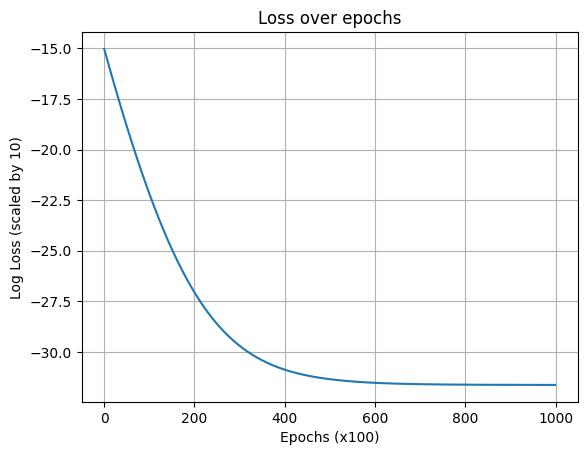

In [23]:
# 손실 그래프
plt.plot(10.0 * np.log(np.array(losses) + 1e-5))
plt.title('Loss over epochs')
plt.xlabel('Epochs (x100)')
plt.ylabel('Log Loss (scaled by 10)')
plt.grid()
plt.show()